## Data Acquisition & Preprocess for Lightning datasets (netCDF files)


In [ ]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
crs = {'init': 'epsg:4326'}

### Tranformation between original and gridded coordinates

In [ ]:
#create two functions to tranfrorm the coords back and forth
res = 0.1   #climatology = 0.5,  LRMTS = 2.5
zone = 38   #climatology = 38,   LRMTS = 90

def gridded_latlon(real_lat, real_lon):
    grid_lat = round((real_lat + zone)/res)
    grid_lon = round((real_lon + 180)/res)
    print(grid_lat, grid_lon)
    return grid_lat, grid_lon


def real_latlon(grid_lat, grid_lon):
    real_lat = grid_lat*res - zone
    real_lon = grid_lon*res - 180
    print(real_lat, real_lon)
    return real_lat, real_lon

In [ ]:
#initial file path
file_path = './LIS_VHRES/data_climatology/'

### Full Climatology - reference spot and data in geodataframe

In [ ]:
frd = Dataset(file_path + 'VHRFC.nc', 'r').variables['VHRFC_LIS_FRD'][:].data

#### Reference spot

In [ ]:
#find the place with the highest flash rate density - keep it in mind as reference spot

maximum  = int(round(np.amax(frd)))
lat = np.where(frd == np.amax(frd))[0][0]
lon = np.where(frd == np.amax(frd))[1][0]

real_lat, real_lon = real_latlon(lat, lon)

print('The place with the highest flash rate density is at lat={}, lon={},\n with a mean of {} flashes per year'.format(round(real_lat), round(real_lon), maximum))

9.700000000000003 -71.69999999999999
The place with the highest flash rate density is at lat=10.0, lon=-72.0,
 with a mean of 233 flashes per year


#### NC file to dataframe

In [ ]:
#open multi-index nc file into dataframe
import xarray as xr
import netCDF4

df = xr.open_dataset(file_path + 'VHRFC.nc').to_dataframe()
df = df.reset_index(level=['Longitude', 'Latitude'])
df = df[df.VHRFC_LIS_FRD > 0]
del df['VHRFC_LIS_VT']
df.reset_index(inplace=True, drop=True)
df

,Latitude,Longitude,VHRFC_LIS_FRD
0,-37.95,-178.75,0.906318
1,-37.95,-177.35,0.903004
2,-37.95,-177.25,0.902887
3,-37.95,-176.95,2.707332
4,-37.95,-176.45,0.940296
...,...,...,...
1515605,37.95,174.15,1.485078
1515606,37.95,174.75,1.173280
1515607,37.95,174.95,1.173879
1515608,37.95,175.05,1.486169


In [ ]:
#save it
df.to_csv('Full_Climatology.csv') 
del df

In [ ]:
#open it
df = pd.read_csv('Full_Climatology.csv')
del df['Unnamed: 0']

In [ ]:
#filter it with a threshold of 5 flashes
df = df[df.VHRFC_LIS_FRD > 5] 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.reset_index(inplace=True, drop=True)
del df
gdf

,Latitude,Longitude,VHRFC_LIS_FRD,geometry
0,-37.95,-143.25,11.821247,POINT (-143.25000 -37.95000)
1,-37.95,-70.25,10.962107,POINT (-70.25000 -37.95000)
2,-37.95,-64.85,5.436871,POINT (-64.85000 -37.95000)
3,-37.95,-64.65,5.594469,POINT (-64.65000 -37.95000)
4,-37.95,-63.65,6.793575,POINT (-63.65000 -37.95000)
...,...,...,...,...
500997,37.95,131.75,5.861458,POINT (131.75000 37.95000)
500998,37.95,136.25,5.857105,POINT (136.25000 37.95000)
500999,37.95,139.35,7.016274,POINT (139.35000 37.95000)
501000,37.95,154.25,5.855022,POINT (154.25000 37.95000)


### The other climatology files - no dataframe

monthly - VHRMC.nc, annual  - VHRAC.nc, diurnal - VHRDC.nc, seasonal- VHRSC.nc

In [ ]:
dataset = Dataset(file_path + 'VHRMC.nc', 'r')
frd = dataset.variables['VHRMC_LIS_FRD'][:].data
frd.shape

(12, 760, 3600)

In [ ]:
#explore the data
print(dataset.variables.keys()) 
print(dataset.variables['VHRMC_LIS_FRD'].dimensions)
print(dataset.variables['VHRMC_LIS_FRD'].shape)

odict_keys(['Longitude', 'Latitude', 'Month', 'VHRMC_LIS_FRD', 'VHRMC_LIS_VT'])
('Month', 'Latitude', 'Longitude')
(12, 760, 3600)


#### Create mask

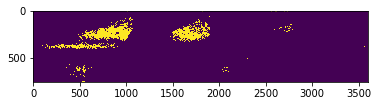

In [ ]:
#we can mask the places where the flashes are constantly 0 (they sum up to 0)
plt.imshow(np.sum(frd,0)==0)

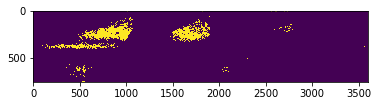

In [ ]:
#create a mask, where the flashes are constantly zero:
mask = np.asarray([np.sum(frd,0)==0])
mask = mask.reshape(760, 3600)

#create layers of masks, to match the data:
masks = np.asarray([mask]*frd.shape[0])

#apply the mask on the data, to mask the unimportant areas:
frd_masked = np.ma.masked_where(masks==True, frd)
frd_masked[masks==True] = np.nan

#check grafically if what we did is correct:
#the plot for sums-over-masked-values has to be the same as the above plot for sums-over-zeros
plt.imshow(np.nansum(np.isnan(frd_masked), 0))

### Low Resolution Monthly Time Series (LRMTS) nc file

In [ ]:
frd = Dataset('./LIS_VHRES/data_climatology/LISOTD_LRMTS.nc', 'r').variables['LRMTS_COM_FR'][:].data

#### Slicing the data: 
we want to keep the measurements from LIS (tropicals and subtropicals)
and exclude the ODT measurements in order to have more reliable results


In [ ]:
#keep the tropicals and subtropicals: find the corresponding gridded latitudes for lat=[-38, 38]
res=2.5
zone=90

gridded_latlon(38, 100)
gridded_latlon(-38, 100)

51 112
21 112


(21, 112)

In [ ]:
#keep the measurements from April 2000 onwards (LIS, without OTD): skip the first 20 months

frd = frd[ 21:52, :, 60:]
frd.shape

(31, 144, 180)

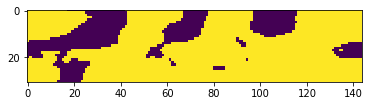

In [ ]:
#take a look of the data
plt.imshow(np.sum(frd,2)>=0.1)

#### Mask the data

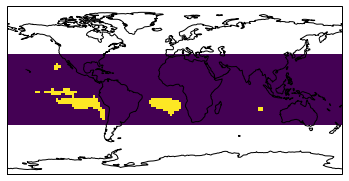

In [ ]:
#where are the flashes constantly very low? 

plt.close('all')
plt.figure() 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])
ax.coastlines()

ax.imshow(np.sum(frd,2)<=0.01, extent = [-180, 180, -38, 38])

plt.show()

In [ ]:
mask = np.asarray([np.sum(frd, 2)<=0.01])